# Generative Adversarial Network

Reference: https://github.com/eriklindernoren/Keras-GAN/

In [26]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
from pathlib import Path
import os

os.chdir('/content/gdrive/My Drive/download-steam-banners/')

image_folder = 'images_steam/'
model_folder = 'saved_model_steam/'

Path(image_folder).mkdir(exist_ok=True)
Path(model_folder).mkdir(exist_ok=True)

!ls

app_ids.txt	   data		     images	   samples
banner_matrix.npy  DCGAN-tensorflow  images_steam  saved_model
checkpoint	   features	     logs	   saved_model_steam


In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy.random import randint, choice
import glob

In [0]:
def get_top_100():
  # Reference: http://steamspy.com/api.php?request=top100in2weeks
  top_100 = [10, 20, 30, 40, 50, 60, 70, 80, 130, 220, 240, 300, 320, 340, 360, 380, 400, 420, 440, 500, 550, 570, 620, 630, 730, 1250, 4000, 7670, 8870, 8930, 10180, 12210, 15700, 20920, 22380, 48000, 49520, 55230, 57300, 72850, 105600, 109600, 113400, 203160, 208090, 209080, 218230, 218620, 219640, 219740, 221380, 222880, 224260, 227300, 227940, 230410, 236390, 238320, 238960, 252490, 252950, 253710, 255710, 271590, 273110, 273350, 278360, 280790, 291480, 291550, 292030, 301520, 304050, 304390, 304930, 319630, 322330, 323370, 333930, 339610, 346110, 346900, 359550, 363970, 377160, 381210, 386360, 407530, 431960, 433850, 439700, 444090, 489830, 506540, 550650, 555570, 578080, 582010, 588430, 863550]
  return top_100

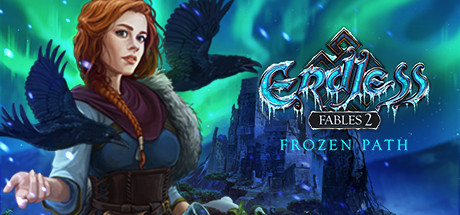

In [31]:
data_dir = 'data/'
image_names = glob.glob(data_dir+'*.jpg')  
image_name = image_names[randint(0, len(image_names))]   
image = load_img(image_name, target_size=(215, 460))
image

In [0]:
def get_matrix_file_name():
  return 'banner_matrix.npy'


In [0]:
def prepare_data_matrix(img_rows=11, img_cols=23, channels=3):  
  data_dir = 'data/'
  
  all_image_names = glob.glob(data_dir+'*.jpg')  
  
  image_names = [img for img in all_image_names if ' (1)' not in img]
  
  num_samples = len(image_names)
  
  X_train = np.zeros((num_samples, img_rows, img_cols, channels))
  
  for counter, image_name in enumerate(sorted(image_names)):
    if counter % 100 == 0:
      print('Iteration {}/{}'.format(counter+1, num_samples)) 
      np.save(get_matrix_file_name(), X_train)

    image = load_img(image_name, target_size=(img_rows, img_cols))
    
    # Grayscale
    if channels==1:
      image = np.mean(image, axis=2)
    
    if channels == 1:
      X_train[counter,:,:] = image
    else:
      X_train[counter,:,:,:] = image    
  
  np.save(get_matrix_file_name(), X_train)
  
  return X_train
  
X_train = prepare_data_matrix()  

Iteration 1/31718
Iteration 101/31718
Iteration 201/31718
Iteration 301/31718
Iteration 401/31718
Iteration 501/31718
Iteration 601/31718
Iteration 701/31718
Iteration 801/31718
Iteration 901/31718
Iteration 1001/31718
Iteration 1101/31718
Iteration 1201/31718
Iteration 1301/31718
Iteration 1401/31718
Iteration 1501/31718
Iteration 1601/31718
Iteration 1701/31718
Iteration 1801/31718
Iteration 1901/31718
Iteration 2001/31718
Iteration 2101/31718
Iteration 2201/31718
Iteration 2301/31718
Iteration 2401/31718
Iteration 2501/31718
Iteration 2601/31718
Iteration 2701/31718
Iteration 2801/31718
Iteration 2901/31718
Iteration 3001/31718
Iteration 3101/31718
Iteration 3201/31718
Iteration 3301/31718
Iteration 3401/31718
Iteration 3501/31718
Iteration 3601/31718
Iteration 3701/31718
Iteration 3801/31718
Iteration 3901/31718
Iteration 4001/31718
Iteration 4101/31718
Iteration 4201/31718
Iteration 4301/31718
Iteration 4401/31718
Iteration 4501/31718
Iteration 4601/31718
Iteration 4701/31718
Iter

In [0]:
X_train = np.load(get_matrix_file_name())

X_train.shape

In [0]:
# Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

class GAN():
    # CODE CHANGED HERE
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED HERE
        X_train = np.load(get_matrix_file_name())
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED HERE
        if self.channels == 1:
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
              # CODE CHANGED HERE
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])                    
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED HERE                
        fig.savefig(image_folder + "%d.png" % epoch)
        plt.close()



In [0]:
gan = GAN()
gan.train(epochs=30000, batch_size=32, sample_interval=200)


In [0]:
# Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

class WGAN():
    # CODE CHANGED HERE  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED HERE
        X_train = np.load(get_matrix_file_name())
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED HERE
        if self.channels == 1:        
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED HERE
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])     
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED HERE                
        fig.savefig(image_folder + "%d.png" % epoch)
        plt.close()


In [0]:
wgan = WGAN()
wgan.train(epochs=4000, batch_size=32, sample_interval=50)

In [0]:
# Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

class DCGAN():
    # CODE CHANGED HERE  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        # CODE CHANGED HERE
        X_train = np.load(get_matrix_file_name())
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED HERE
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED HERE
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED HERE                
        fig.savefig(image_folder + "%d.png" % epoch)
        plt.close()


In [0]:
dcgan = DCGAN()
dcgan.train(epochs=4000, batch_size=32, save_interval=50)